In [3]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.graph_objs import *

C:\Users\bujno\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Load image set

In [4]:
dicom_image_set = glob("DICOM/*.dcm")
dicom_folder_path = "DICOM"
dicom_data_output = "Output/"

### Helper functions

- load_scan - convert dicom images to list
- get_pixels_hu - convert raw values to Hiundsfeld units

To understand used DICOM methods check for example https://dicom.innolitics.com/ciods/ct-image/ct-image/00281052

In [5]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + slice, force=True) for slice in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for slice in slices:
        slice.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    image = np.stack([scan.pixel_array for scan in scans])
    image = image.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [6]:
patient = load_scan(dicom_folder_path)
print(patient)

[Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.995654199437862485099260177642
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.99

In [7]:
imgs = get_pixels_hu(patient)
print(imgs)

[[[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 ...

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -10

Save new data to not reproduce above code everytime

In [8]:
np.save(dicom_data_output + "fullimages.npy", imgs)

### Histogram of image data

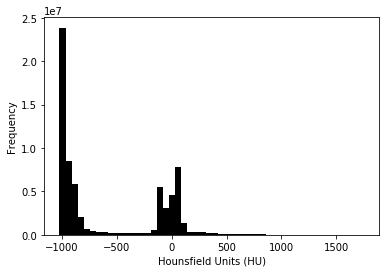

In [9]:
file = dicom_data_output + "fullimages.npy"
imgs_to_process = np.load(file).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='black')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

Conclusions based of histogram:
- There is a lots of air
- There is some lung
- There is a lot soft tissue, but there's also some fat
- There is a small bit of bones

For more visit HU table in README file. 

### Display an image slices

In [10]:
def show_stack_images(stack_images, rows=6, cols=6, start_with=10, show_every=3):
    _, ax = plt.subplots(rows, cols, figsize=[12,12])
    for i in range(rows * cols):
        index = start_with + i * show_every
        ax[int(i/rows),int(i % rows)].set_title(f'Slice {index}')
        ax[int(i/rows),int(i % rows)].imshow(stack_images[index],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

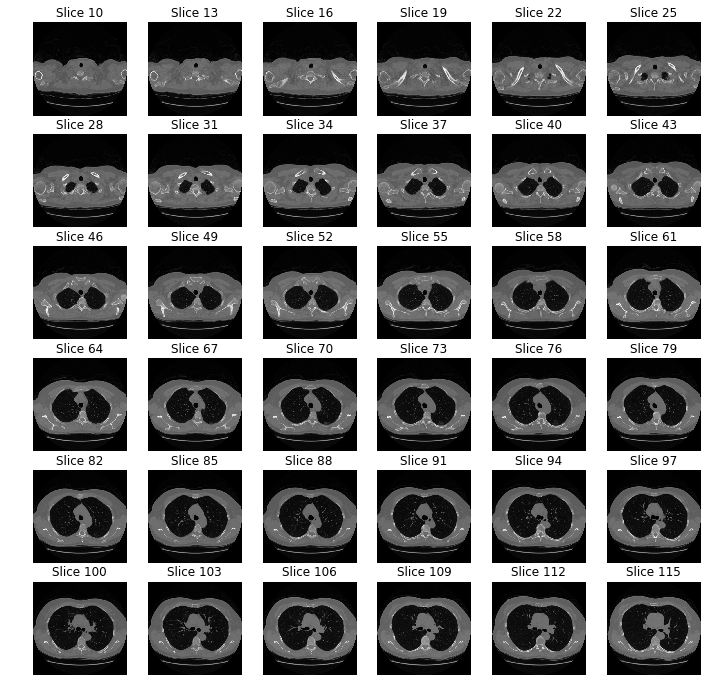

In [11]:
show_stack_images(imgs_to_process)

## Resampling

We have to know how thick each slice is. This informations are placed in DICOM Header, so we can get them really easly.

In [12]:
print(f"Slice Thickness: {patient[0].SliceThickness}")
print(f"Pixel Spacing (row, col): {patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]}")

Slice Thickness: 1.25
Pixel Spacing (row, col): ('0.681641', '0.681641')


So we know that have 1.25mm slices and each voxel is 0.7mm. Because a CT slice is typically reconstructed at 512 x 512 voxels, each slice represents approximately 370 mm of data in length a

In [13]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    pixel_spacing = scan[0].PixelSpacing
    original_z_spacing = np.abs(scan[0].ImagePositionPatient[2] - scan[1].ImagePositionPatient[2])
    spacing = np.array([float(pixel_spacing[0]), float(pixel_spacing[1]), original_z_spacing], dtype='float32')
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print(f"Shape before resampling {imgs_to_process.shape}")
imgs_after_resamp, spacing = resample(imgs_to_process, patient)
print(f"Shape after resampling {imgs_after_resamp.shape}")

Shape before resampling (261, 512, 512)
Shape after resampling (178, 349, 640)


## Segmentation

For more information about measure module - https://scikit-image.org/docs/dev/api/skimage.measure.html

In [23]:
from scipy.spatial import ConvexHull

def set_is_closed(contour):
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    if np.sqrt(np.power(dx, 2) + np.power(dy, 2)) < 1:
        return True
    else:
        return False

def make_lungmask(img, display=False, save_contour_png=False, i=0):
    #Standardize the pixel values
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, Let's moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    
    # Create contours 
    contours =  measure.find_contours(img, 0.8)
    body_and_lung_contours = []
    for contour in contours:
        hull = ConvexHull(contour)
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
    contours = body_and_lung_contours

    # After just the lungs are left, we do another large dilation
    # in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(4, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Contours")
        ax[2, 1].imshow(img, cmap='gray')
        for contour in contours:
            ax[2, 1].plot(contour[:, 1], contour[:, 0], linewidth=2)
        ax[2, 1].axis('off')
        ax[3, 0].set_title("Apply Mask on Original")
        ax[3, 0].imshow(mask*img, cmap='gray')
        ax[3, 0].axis('off')
        ax[3, 1].set_xticks([])
        ax[3, 1].set_yticks([])
        plt.show()
    
    if save_contour_png:
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray')
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        ax.axis('off')
        plt.savefig(f'Output/GIF_data/contours_{i}.png')
    return mask*img

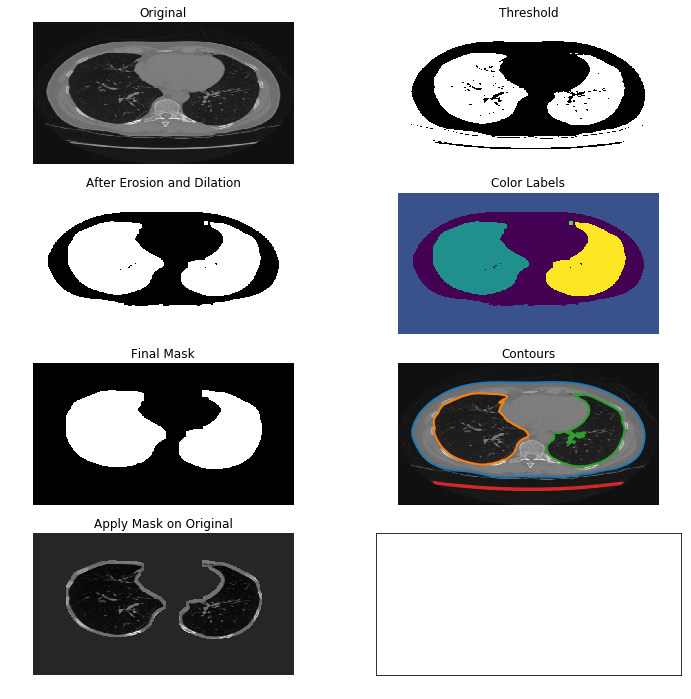

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [19]:
img = imgs_after_resamp[120]
make_lungmask(img, display=True)

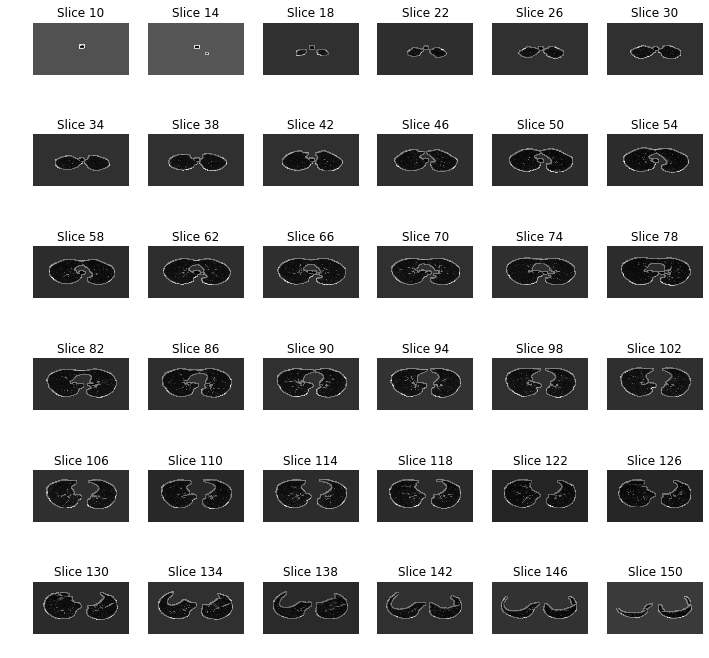

In [16]:
masked_lung = []

for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))

show_stack_images(masked_lung, show_every=4)
np.save(dicom_data_output + "maskedimages.npy", imgs)

### Additional function to save all slices as one image

In [ ]:
for i, slice in enumerate(imgs_to_process):
   make_lungmask(slice, save_contour_png=True, i=i)

In [29]:
import imageio

with imageio.get_writer('contour.gif', mode='I') as writer:
    dir_list = os.listdir('Output/GIF_data')
    for i in range(len(dir_list)):
        image = imageio.imread(f'Output/GIF_data/contours_{i}.png')
        writer.append_data(image)